# Process true trajectories

Aggregate, process, plot some and save all true trajectories' features. 

---

# Imports

In [149]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

In [150]:
plt.style.use("ggplot")
sns.set_context("paper")

# Explore individual files (for one single video)

In [151]:
data_path = Path("analyses", "biotine_resized")

In [152]:
plate = "A_13_fld_4"

cell_nucleus = pd.read_csv(data_path / "measurements" / plate / "cell_nucleus.csv")
filtered_nucleus = pd.read_csv(data_path / "measurements" / plate / "filtered_nucleus.csv")
image = pd.read_csv(data_path / "measurements" / plate / "Image.csv")
whole_cell = pd.read_csv(data_path / "measurements" / plate / "whole_cell.csv")

print("cell_nucleus:", cell_nucleus.columns)
print("filtered_nucleus:", filtered_nucleus.columns)
print("image:", image.columns)
print("whole_cell:", whole_cell.columns)

cell_nucleus: Index(['ImageNumber', 'ObjectNumber', 'Metadata_FileLocation',
       'Metadata_Frame', 'Metadata_Series', 'Metadata_VideoID',
       'Metadata_VideoID.1', 'Metadata_Well', 'Metadata_column',
       'Metadata_field', 'Metadata_row', 'Metadata_time',
       'FileName_base_images', 'PathName_base_images',
       'Children_filtered_nucleus_Count', 'Children_whole_cell_Count',
       'Location_Center_X', 'Location_Center_Y', 'Location_Center_Z',
       'Number_Object_Number'],
      dtype='object')
filtered_nucleus: Index(['ImageNumber', 'ObjectNumber', 'Metadata_FileLocation',
       'Metadata_Frame', 'Metadata_Series', 'Metadata_VideoID',
       'Metadata_VideoID.1', 'Metadata_Well', 'Metadata_column',
       'Metadata_field',
       ...
       'TrackObjects_DistanceTraveled_10', 'TrackObjects_FinalAge_10',
       'TrackObjects_IntegratedDistance_10', 'TrackObjects_Label_10',
       'TrackObjects_Lifetime_10', 'TrackObjects_Linearity_10',
       'TrackObjects_ParentImageNum

In [153]:
print(
    "common columns:",
    set(cell_nucleus.columns)
    & set(filtered_nucleus.columns)
    & set(image.columns)
    & set(whole_cell.columns),
)

common columns: {'Metadata_time', 'Metadata_Frame', 'FileName_base_images', 'Metadata_column', 'Metadata_Series', 'PathName_base_images', 'Metadata_FileLocation', 'Metadata_field', 'Metadata_Well', 'Metadata_VideoID', 'Metadata_row', 'ImageNumber'}


In [154]:
image

,Channel_base_images,Count_cell_nucleus,Count_filtered_nucleus,Count_whole_cell,ExecutionTime_01Images,ExecutionTime_02Metadata,ExecutionTime_03NamesAndTypes,ExecutionTime_04Groups,ExecutionTime_05Resize,ExecutionTime_06ColorToGray,...,Threshold_SumOfEntropies_cell_nucleus,Threshold_SumOfEntropies_whole_cell,Threshold_WeightedVariance_cell_nucleus,Threshold_WeightedVariance_whole_cell,TrackObjects_LostObjectCount_filtered_nucleus_10,TrackObjects_MergedObjectCount_filtered_nucleus_10,TrackObjects_NewObjectCount_filtered_nucleus_10,TrackObjects_SplitObjectCount_filtered_nucleus_10,URL_base_images,Width_base_images
0,-2,492.0,479.0,479.0,0.0,0.0,1.48,0.0,3.06,0.05,...,-12.746156,-12.751976,0.078043,0.017962,0,0,479,0,file:/projects/static2dynamic/datasets/biotine...,2040
1,-2,498.0,482.0,482.0,0.0,0.0,1.54,0.0,1.31,0.08,...,-12.748243,-12.792656,0.079258,0.019900,6,17,6,23,file:/projects/static2dynamic/datasets/biotine...,2040
2,-2,496.0,479.0,479.0,0.0,0.0,0.85,0.0,1.03,0.01,...,-12.698429,-12.846931,0.080413,0.023423,4,14,7,22,file:/projects/static2dynamic/datasets/biotine...,2040
3,-2,488.0,473.0,473.0,0.0,0.0,0.98,0.0,1.03,0.01,...,-12.676875,-12.940988,0.079702,0.029316,4,13,2,22,file:/projects/static2dynamic/datasets/biotine...,2040
4,-2,493.0,481.0,481.0,0.0,0.0,0.79,0.0,0.98,0.01,...,-12.597422,-12.989902,0.077917,0.036185,2,11,10,25,file:/projects/static2dynamic/datasets/biotine...,2040
5,-2,500.0,490.0,490.0,0.0,0.0,0.92,0.0,0.83,0.01,...,-12.575683,-12.767485,0.076842,0.037504,6,9,4,42,file:/projects/static2dynamic/datasets/biotine...,2040
6,-2,491.0,483.0,483.0,0.0,0.0,0.87,0.0,0.99,0.01,...,-12.549511,-12.626266,0.076260,0.036319,4,19,6,36,file:/projects/static2dynamic/datasets/biotine...,2040
7,-2,496.0,491.0,491.0,0.0,0.0,0.78,0.0,0.90,0.02,...,-12.570236,-12.700137,0.075436,0.035975,5,8,7,42,file:/projects/static2dynamic/datasets/biotine...,2040
8,-2,496.0,491.0,491.0,0.0,0.0,0.85,0.0,0.99,0.01,...,-12.517141,-12.796803,0.074647,0.036772,4,11,4,45,file:/projects/static2dynamic/datasets/biotine...,2040
9,-2,495.0,489.0,489.0,0.0,0.0,1.17,0.0,1.24,0.01,...,-12.523657,-12.841929,0.074019,0.038074,1,13,3,45,file:/projects/static2dynamic/datasets/biotine...,2040


In [155]:
cell_nucleus

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,Metadata_row,Metadata_time,FileName_base_images,PathName_base_images,Children_filtered_nucleus_Count,Children_whole_cell_Count,Location_Center_X,Location_Center_Y,Location_Center_Z,Number_Object_Number
0,51,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,0,0,271.126761,12.216901,0,1
1,51,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,239.844156,20.288312,0,2
2,51,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,203.665816,18.329082,0,3
3,51,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,485.835420,20.139535,0,4
4,51,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,1,A_13_fld_4_time_01.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,84.524631,22.701970,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9382,69,500,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,927.294235,1005.200795,0,500
9383,69,501,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,0,0,735.507123,1003.943020,0,501
9384,69,502,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,0,0,756.605882,1005.500000,0,502
9385,69,503,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,A,19,A_13_fld_4_time_19.png,/projects/static2dynamic/datasets/biotine/3_ch...,1,1,441.810078,1009.794574,0,503


In [156]:
filtered_nucleus

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_DistanceTraveled_10,TrackObjects_FinalAge_10,TrackObjects_IntegratedDistance_10,TrackObjects_Label_10,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10
0,51,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,1,1,NaN,0.0,0,0.000000,0.000000
1,51,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,2,1,NaN,0.0,0,0.000000,0.000000
2,51,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,3,1,NaN,0.0,0,0.000000,0.000000
3,51,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,4,1,NaN,0.0,0,0.000000,0.000000
4,51,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.000000,NaN,0.000000,5,1,NaN,0.0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9190,69,489,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.581294,15.0,18.348639,502,15,0.625059,68.0,487,-0.454540,0.362348
9191,69,490,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,1.076738,19.0,53.264649,471,19,0.510972,68.0,488,0.803989,-0.716217
9192,69,491,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.829828,10.0,6.540967,528,10,0.814149,68.0,490,-0.335544,-0.758963
9193,69,492,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.370368,13.0,10.032015,514,13,0.762364,68.0,492,-0.286219,-0.235056


In [157]:
whole_cell

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,AreaShape_Zernike_9_3,AreaShape_Zernike_9_5,AreaShape_Zernike_9_7,AreaShape_Zernike_9_9,Location_Center_X,Location_Center_Y,Location_Center_Z,Number_Object_Number,Parent_cell_nucleus,Parent_filtered_nucleus
0,51,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.004803,0.005243,0.005233,0.003059,239.844156,20.288312,0,1,2,1
1,51,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.002433,0.004430,0.002004,0.002386,204.676812,24.342029,0,2,3,2
2,51,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.009309,0.010366,0.008940,0.007028,487.893475,24.171771,0,3,4,3
3,51,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.008089,0.006735,0.004584,0.002222,84.524631,22.701970,0,4,5,4
4,51,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.005029,0.001795,0.005042,0.007247,166.276627,30.502219,0,5,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9190,69,489,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.005635,0.007507,0.006190,0.004352,495.124031,996.248062,0,489,496,489
9191,69,490,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.011309,0.005943,0.004068,0.004011,592.099265,1001.106618,0,490,498,490
9192,69,491,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.002312,0.006498,0.004396,0.004936,927.757798,1004.577982,0,491,500,491
9193,69,492,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_4,A_13_fld_4,A13,13,4,...,0.008998,0.008937,0.007412,0.004073,441.810078,1009.794574,0,492,503,492


# Concat individual video data

In [158]:
all_csv_files = [
    f
    for f in data_path.rglob("*.csv")
    if f.name in ["whole_cell.csv", "filtered_nucleus.csv"]  # take only the filtered files
    and f.stem != "Experiment"
    and not f.stem.startswith("features_through_time")
]
print(f"Found {len(all_csv_files)} csv files")

Found 240 csv files


##  Add identifiers to know from which csv file the data comes from

In [159]:
def process_file(f: Path):
    smol_df = pd.read_csv(f)
    smol_df["file"] = f.stem
    return smol_df


with ThreadPoolExecutor() as executor:
    all_smol_dfs = list(tqdm(executor.map(process_file, all_csv_files), total=len(all_csv_files)))

  0%|          | 0/240 [00:00<?, ?it/s]

## Concat data

In [160]:
df = pd.concat(all_smol_dfs, ignore_index=True)
df

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_IntegratedDistance_10,TrackObjects_Label_10,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus
0,13,1,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,0.0,1.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
1,13,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,0.0,2.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
2,13,3,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,0.0,3.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
3,13,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,0.0,4.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
4,13,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,0.0,5.0,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146353,2254,409,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,409.0
2146354,2254,410,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,410.0
2146355,2254,411,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,411.0
2146356,2254,412,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,412.0


## Check the video ID & time

### video ID

In [161]:
df["Metadata_VideoID"].value_counts(dropna=False)

Metadata_VideoID
B_14_fld_2    24162
G_13_fld_2    22842
B_13_fld_2    22628
E_14_fld_2    22614
F_14_fld_2    22602
              ...  
G_13_fld_3    11790
E_13_fld_3    11586
D_14_fld_3    11002
A_14_fld_3    10348
A_13_fld_3     8850
Name: count, Length: 120, dtype: int64

In [162]:
df["Metadata_VideoID"].isna().sum()

0

In [163]:
mask = df["Metadata_VideoID"].isna()
assert not mask.any()
# df.loc[mask, "Metadata_VideoID"] = df["FileName_images"].str.split("_time_").str[0]

In [164]:
df["Metadata_VideoID"].value_counts(dropna=False)

Metadata_VideoID
B_14_fld_2    24162
G_13_fld_2    22842
B_13_fld_2    22628
E_14_fld_2    22614
F_14_fld_2    22602
              ...  
G_13_fld_3    11790
E_13_fld_3    11586
D_14_fld_3    11002
A_14_fld_3    10348
A_13_fld_3     8850
Name: count, Length: 120, dtype: int64

### Check the time

In [165]:
df["Metadata_time"].value_counts(dropna=False)

Metadata_time
19    115098
18    114894
17    114858
15    114590
16    114510
14    114324
11    113758
7     113148
13    113046
12    112784
10    112674
9     112586
8     112570
6     112524
4     111634
2     111374
1     111214
5     110580
3     110192
Name: count, dtype: int64

In [166]:
df["Metadata_time"].isna().sum()

0

In [167]:
mask = df["Metadata_time"].isna()
assert not mask.any()
# df.loc[mask, "Metadata_time"] = (
# df["FileName_images"].str.extract(r"_time_(.*?)\.")[0].astype(df["Metadata_time"].dtype)
# )

In [168]:
df["Metadata_time"].value_counts(dropna=False)

Metadata_time
19    115098
18    114894
17    114858
15    114590
16    114510
14    114324
11    113758
7     113148
13    113046
12    112784
10    112674
9     112586
8     112570
6     112524
4     111634
2     111374
1     111214
5     110580
3     110192
Name: count, dtype: int64

# Basic analysis & statistics

In [169]:
list(df.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_VideoID',
 'Metadata_VideoID.1',
 'Metadata_Well',
 'Metadata_column',
 'Metadata_field',
 'Metadata_row',
 'Metadata_time',
 'FileName_base_images',
 'PathName_base_images',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_Equival

In [170]:
# 119 full videos and one with 7 filtered frames
assert (nb_imgs := len(df["ImageNumber"].unique())) == (theory := 19 * 119 + 12), (
    f"{nb_imgs} != {theory}"
)

In [171]:
df["file"].value_counts(dropna=False)

file
filtered_nucleus    1073179
whole_cell          1073179
Name: count, dtype: int64

## Lifetime of objects

### Instantaneous lifetime

In [172]:
# check that lines with NaN in TrackObjects_Lifetime_10 are from whole_cell, exclusively
assert all(df.loc[df["TrackObjects_Lifetime_10"].isna(), "file"] == "whole_cell")
assert all(df.loc[df["file"] == "whole_cell", "TrackObjects_Lifetime_10"].isna())
df.groupby("file")["TrackObjects_Lifetime_10"].value_counts(dropna=False)

file              TrackObjects_Lifetime_10
filtered_nucleus  1.0                           64432
                  2.0                           61215
                  3.0                           59729
                  4.0                           58710
                  5.0                           57870
                  6.0                           57436
                  7.0                           57104
                  8.0                           56763
                  9.0                           56434
                  10.0                          56077
                  11.0                          55740
                  12.0                          55511
                  13.0                          54661
                  14.0                          54355
                  15.0                          54076
                  16.0                          53711
                  17.0                          53477
                  18.0                 

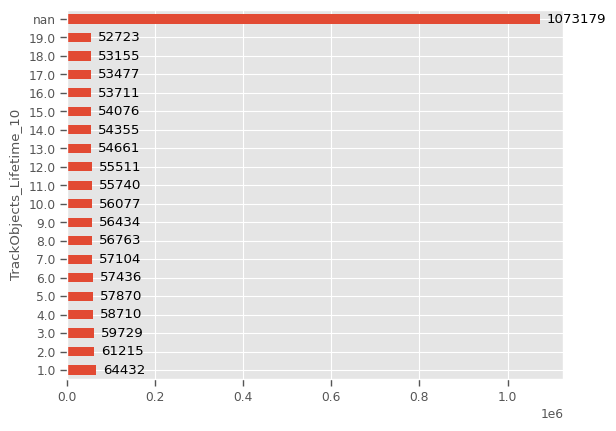

In [173]:
ax = df["TrackObjects_Lifetime_10"].value_counts(dropna=False).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

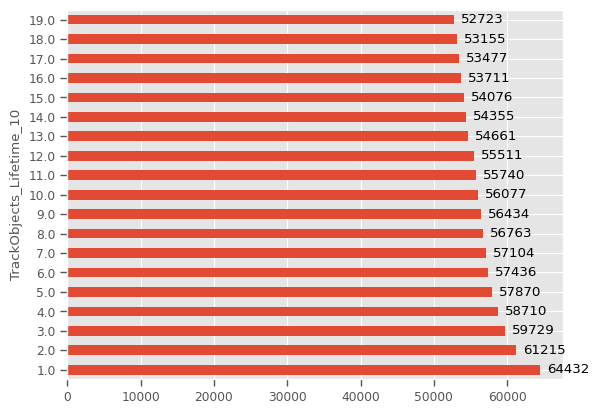

In [174]:
ax = df["TrackObjects_Lifetime_10"].value_counts(dropna=True).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

### Final lifetime

In [175]:
df.groupby("file")["TrackObjects_FinalAge_10"].value_counts(dropna=False)

file              TrackObjects_FinalAge_10
filtered_nucleus  NaN                         1000671
                  19.0                          52723
                  1.0                            5874
                  2.0                            2329
                  3.0                            1520
                  4.0                            1205
                  12.0                           1049
                  5.0                             883
                  6.0                             774
                  7.0                             744
                  8.0                             689
                  9.0                             621
                  18.0                            588
                  10.0                            568
                  11.0                            529
                  16.0                            528
                  14.0                            491
                  17.0                 

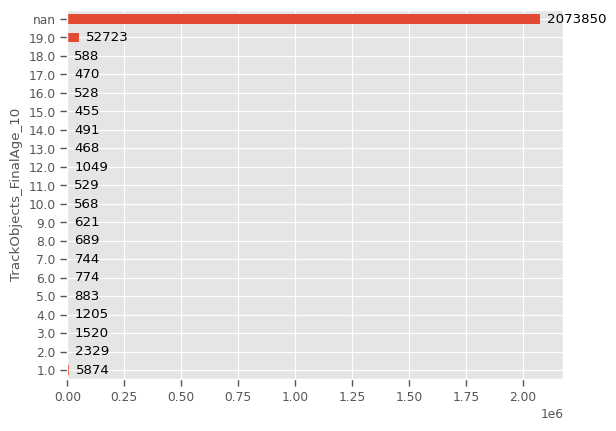

In [176]:
ax = df["TrackObjects_FinalAge_10"].value_counts(dropna=False).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

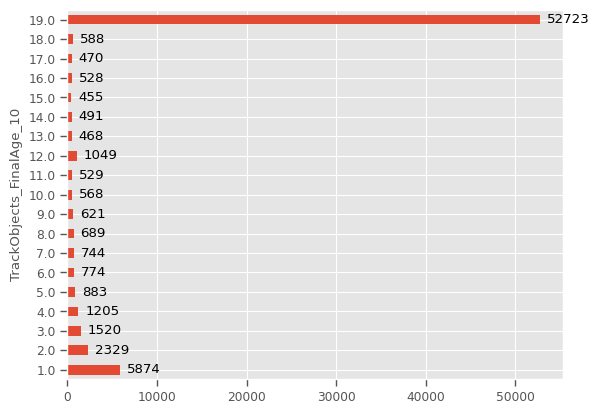

In [177]:
ax = df["TrackObjects_FinalAge_10"].value_counts(dropna=True).sort_index().plot(kind="barh")
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=5)

# Select objects with full lifetime 

(ie final age 19)

## First assign a global object ID

### ObjectNumber analysis 

(not an actual object identifier as not coherent through time)

In [178]:
assert not df["Metadata_VideoID"].isna().any()
print(df["ObjectNumber"].isna().sum())  # these are potential image files, it's ok
df[df["ObjectNumber"].isna()]["file"]

0


Series([], Name: file, dtype: object)

In [179]:
df["not_an_id"] = df["Metadata_VideoID"].astype(str) + "-" + df["ObjectNumber"].astype(str)
assert not df["not_an_id"].isna().any()
df["not_an_id"].value_counts(dropna=False)

not_an_id
A_13_fld_2-1      38
K_13_fld_2-36     38
K_13_fld_2-25     38
K_13_fld_2-26     38
K_13_fld_2-27     38
                  ..
B_14_fld_3-387     2
N_14_fld_2-526     2
N_14_fld_2-527     2
N_14_fld_2-528     2
O_14_fld_3-416     2
Name: count, Length: 58319, dtype: int64

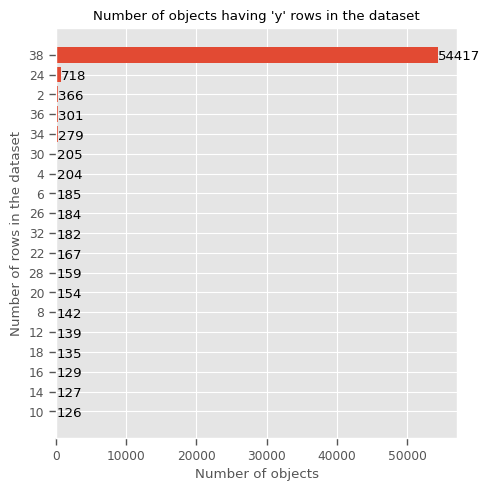

In [180]:
plt.figure(figsize=(5, 5))
x, y = np.unique(df["not_an_id"].value_counts(dropna=False).values, return_counts=True)
sorted_indices = np.argsort(y)
y = y[sorted_indices]
x = x[sorted_indices]
plt.yticks(ticks=np.arange(len(x)), labels=x)
bars = plt.barh(np.arange(len(x)), y)
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2 - 0.1,
        bar.get_width(),
        va="center",
    )
plt.xlabel("Number of objects")
plt.ylabel("Number of rows in the dataset")
plt.title("Number of objects having 'y' rows in the dataset")
plt.tight_layout()
# plt.xscale("log")
plt.show()

### TrackObjects_Label_10 analysis

In [181]:
df.groupby("file")["TrackObjects_Label_10"].apply(lambda x: x.isna().sum())

file
filtered_nucleus          0
whole_cell          1073179
Name: TrackObjects_Label_10, dtype: int64

TrackObjects_Label_10 is only assigned to filtered_nucleus, and assigned to all of them

In [182]:
maks_trackobject_label_exists = df["TrackObjects_Label_10"].notna()
df.loc[maks_trackobject_label_exists, "global_object_id"] = (
    df["Metadata_VideoID"].astype(str) + "-" + df["TrackObjects_Label_10"].astype(str)
)
df["global_object_id"].value_counts(dropna=False)

global_object_id
NaN                 1073179
I_14_fld_2-257.0         80
C_14_fld_3-150.0         73
L_13_fld_2-306.0         69
C_14_fld_2-498.0         65
                     ...   
G_13_fld_3-319.0          1
N_13_fld_3-5.0            1
G_13_fld_3-324.0          1
G_13_fld_3-326.0          1
O_14_fld_3-449.0          1
Name: count, Length: 64433, dtype: int64

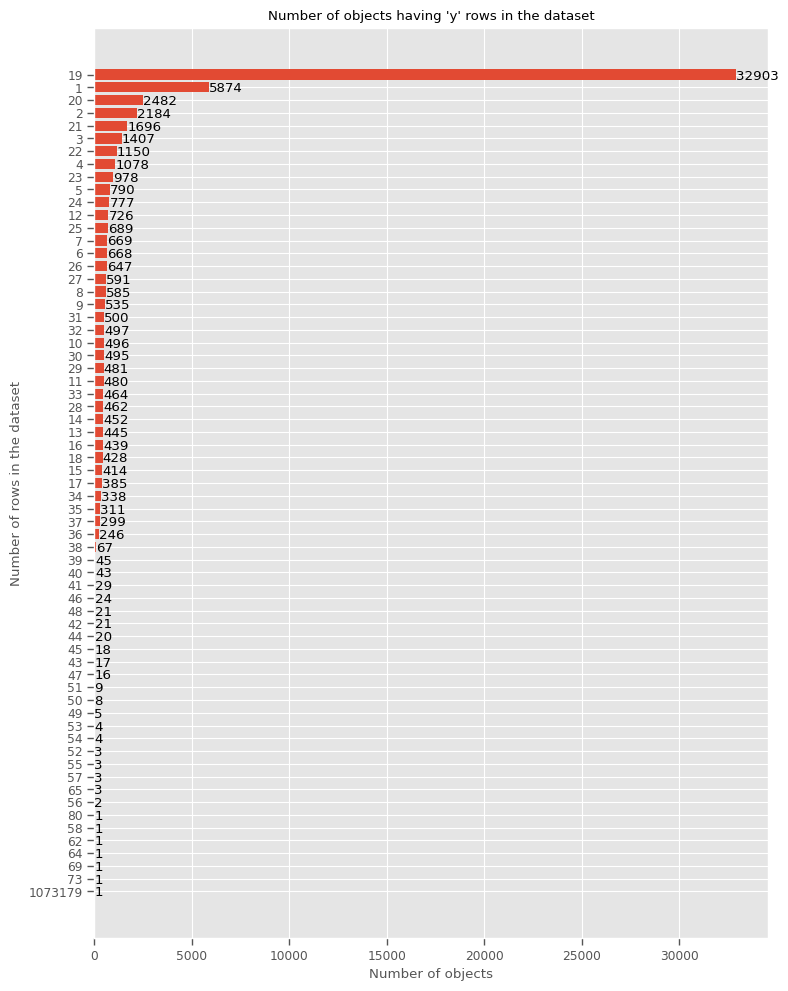

In [183]:
plt.figure(figsize=(8, 10))
x, y = np.unique(df["global_object_id"].value_counts(dropna=False).values, return_counts=True)
sorted_indices = np.argsort(y)
y = y[sorted_indices]
x = x[sorted_indices]
plt.yticks(ticks=np.arange(len(x)), labels=x)
bars = plt.barh(np.arange(len(x)), y)
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2 - 0.1,
        bar.get_width(),
        va="center",
    )
plt.title("Number of objects having 'y' rows in the dataset")
plt.xlabel("Number of objects")
plt.ylabel("Number of rows in the dataset")
plt.tight_layout()
# plt.xscale("log")
plt.show()

`TrackObjects_Label_10` is the correct object ID

Some checks:

In [184]:
df.groupby("global_object_id")["TrackObjects_FinalAge_10"].unique()

global_object_id
A_13_fld_1-1.0       [nan, 5.0]
A_13_fld_1-10.0     [nan, 12.0]
A_13_fld_1-100.0    [nan, 12.0]
A_13_fld_1-101.0     [nan, 3.0]
A_13_fld_1-102.0    [nan, 12.0]
                       ...     
O_14_fld_4-95.0     [nan, 19.0]
O_14_fld_4-96.0           [1.0]
O_14_fld_4-97.0           [1.0]
O_14_fld_4-98.0     [nan, 19.0]
O_14_fld_4-99.0     [nan, 19.0]
Name: TrackObjects_FinalAge_10, Length: 64432, dtype: object

In [185]:
df.groupby("global_object_id")["TrackObjects_ParentObjectNumber_10"].unique()

global_object_id
A_13_fld_1-1.0                                        [0.0, 1.0, 2.0]
A_13_fld_1-10.0           [0.0, 10.0, 11.0, 13.0, 8.0, 7.0, 6.0, 9.0]
A_13_fld_1-100.0    [0.0, 100.0, 103.0, 99.0, 98.0, 107.0, 104.0, ...
A_13_fld_1-101.0                                  [0.0, 101.0, 109.0]
A_13_fld_1-102.0    [0.0, 102.0, 104.0, 108.0, 101.0, 105.0, 99.0,...
                                          ...                        
O_14_fld_4-95.0     [0.0, 95.0, 100.0, 107.0, 104.0, 105.0, 108.0,...
O_14_fld_4-96.0                                                 [0.0]
O_14_fld_4-97.0                                                 [0.0]
O_14_fld_4-98.0     [0.0, 98.0, 104.0, 111.0, 110.0, 114.0, 108.0,...
O_14_fld_4-99.0     [0.0, 99.0, 106.0, 103.0, 109.0, 110.0, 100.0,...
Name: TrackObjects_ParentObjectNumber_10, Length: 64432, dtype: object

## Then filter on objects with full lifetime

Note that objects with full lifetime might still split / merge somehow, see CellProfiler TrackObject doc.

**Important: we still want to keep the whole_cell measurements; they do not have a *global_object_id* for now!**

### First some checks

In [186]:
mask_objects_with_full_lifetime = df["TrackObjects_FinalAge_10"] == 19
objects_with_full_lifetime_ids = df.loc[
    mask_objects_with_full_lifetime, "global_object_id"
].unique()
print(f"There are {len(objects_with_full_lifetime_ids)} object IDs with full lifetime (19).")
objects_with_full_lifetime_ids  # these are all objects IDs with full lifetime (19)

There are 45757 object IDs with full lifetime (19).


array(['A_13_fld_2-2.0', 'A_13_fld_2-4.0', 'A_13_fld_2-5.0', ...,
       'O_14_fld_3-393.0', 'O_14_fld_3-392.0', 'O_14_fld_3-397.0'],
      dtype=object)

Some of these object IDs have multiple lines per time, eg @ time 19:

In [187]:
nb_base_obj_per_global_obj_time_19 = (
    df.loc[mask_objects_with_full_lifetime & (df["Metadata_time"] == 19)]
    .groupby("global_object_id")["ObjectNumber"]
    .nunique()
)

global_obj_ids_with_multiple = nb_base_obj_per_global_obj_time_19[
    nb_base_obj_per_global_obj_time_19 > 1
].index

In [188]:
df.loc[
    df["global_object_id"].isin(global_obj_ids_with_multiple) & (df["Metadata_time"] == 19),
    ["global_object_id", "ObjectNumber"],
].groupby("global_object_id").nunique(dropna=False).sort_values(
    "ObjectNumber", ascending=False, na_position="first"
)

,ObjectNumber
global_object_id,
C_14_fld_3-150.0,8
I_14_fld_1-260.0,7
I_14_fld_2-257.0,6
C_14_fld_2-498.0,5
K_14_fld_3-279.0,5
...,...
F_14_fld_2-146.0,2
F_14_fld_2-120.0,2
F_14_fld_2-12.0,2


but still only a single line per object-id + object number:

In [189]:
display(
    df.loc[
        df["global_object_id"].isin(global_obj_ids_with_multiple) & (df["Metadata_time"] == 19),
        ["global_object_id", "ObjectNumber"],
    ]
    .groupby("global_object_id")
    .value_counts(dropna=False)
    .sort_values(ascending=False, na_position="first")
)

global_object_id  ObjectNumber
A_13_fld_2-106.0  103             1
J_14_fld_4-61.0   67              1
J_14_fld_4-467.0  476             1
J_14_fld_4-473.0  472             1
                  493             1
                                 ..
F_13_fld_1-138.0  148             1
                  154             1
F_13_fld_1-156.0  163             1
                  168             1
O_14_fld_4-99.0   112             1
Name: count, Length: 13457, dtype: int64

check on all times:

In [190]:
df.loc[
    df["global_object_id"].isin(global_obj_ids_with_multiple),
    ["global_object_id", "ObjectNumber", "Metadata_time"],
].groupby("global_object_id").value_counts(dropna=False).sort_values(
    ascending=False, na_position="first"
)

global_object_id  ObjectNumber  Metadata_time
A_13_fld_2-106.0  103           19               1
K_13_fld_1-133.0  135           19               1
                  139           16               1
                                10               1
                                7                1
                                                ..
F_13_fld_1-283.0  304           18               1
                  306           11               1
                  307           13               1
                                16               1
O_14_fld_4-99.0   118           15               1
Name: count, Length: 188538, dtype: int64

### Now assign global object IDs to "whole_cell" objects

because for now:

In [191]:
df.loc[df["global_object_id"].isin(objects_with_full_lifetime_ids), "file"].unique()

array(['filtered_nucleus'], dtype=object)

To assign the global object ID to the whole_cell objects, we "join" the filtered_nucleus and whole_cell dataframes on the frame (ie a video at a certain time) and the `ObjectNumber`. 

Check: we should see exactly 2 lines for each key: a whole_cell and a filtered_nucleus object.

In [192]:
tmp_check = df.groupby(["FileName_base_images", "ObjectNumber"])["file"].value_counts(dropna=False)
display(tmp_check)
assert not tmp_check.isna().any()
assert len(tmp_check) == len(df)
assert tmp_check.unique() == [1]  # always 1 line per key and file type

FileName_base_images    ObjectNumber  file            
A_13_fld_1_time_01.png  1             filtered_nucleus    1
                                      whole_cell          1
                        2             whole_cell          1
                                      filtered_nucleus    1
                        3             whole_cell          1
                                                         ..
O_14_fld_4_time_19.png  439           filtered_nucleus    1
                        440           whole_cell          1
                                      filtered_nucleus    1
                        441           filtered_nucleus    1
                                      whole_cell          1
Name: count, Length: 2146358, dtype: int64

Now assign the global object ID to the whole_cell objects:

In [193]:
# first get the local id -> global id mapping

series_of_global_ids_indexed_by_local_id = df[df["file"] == "filtered_nucleus"].set_index(
    ["FileName_base_images", "ObjectNumber"]
)["global_object_id"]
series_of_global_ids_indexed_by_local_id

FileName_base_images    ObjectNumber
A_13_fld_2_time_01.png  1                 A_13_fld_2-1.0
                        2                 A_13_fld_2-2.0
                        3                 A_13_fld_2-3.0
                        4                 A_13_fld_2-4.0
                        5                 A_13_fld_2-5.0
                                              ...       
O_14_fld_3_time_19.png  409             O_14_fld_3-393.0
                        410             O_14_fld_3-392.0
                        411             O_14_fld_3-445.0
                        412             O_14_fld_3-438.0
                        413             O_14_fld_3-397.0
Name: global_object_id, Length: 1073179, dtype: object

In [ ]:
# then fill the whole_cell global_object_id column
whole_cell_mask = df["file"] == "whole_cell"

lookup_idx = pd.MultiIndex.from_frame(
    df.loc[whole_cell_mask, ["FileName_base_images", "ObjectNumber"]]
)

df.loc[whole_cell_mask, "global_object_id"] = series_of_global_ids_indexed_by_local_id.loc[
    lookup_idx
].values

assert all(df.groupby(["FileName_base_images", "ObjectNumber"])["global_object_id"].nunique() == 1)

### Finally filter the data on objects having full lifetime

In [195]:
assert not df["global_object_id"].isna().any()

In [196]:
df_full_lifetimes = df[df["global_object_id"].isin(objects_with_full_lifetime_ids)]
df_full_lifetimes

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus,not_an_id,global_object_id
1,13,2,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_13_fld_2-2,A_13_fld_2-2.0
3,13,4,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_13_fld_2-4,A_13_fld_2-4.0
4,13,5,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_13_fld_2-5,A_13_fld_2-5.0
5,13,6,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_13_fld_2-6,A_13_fld_2-6.0
7,13,8,file:/projects/static2dynamic/datasets/biotine...,0,0,A_13_fld_2,A_13_fld_2,A13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,A_13_fld_2-8,A_13_fld_2-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146351,2254,407,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,407.0,O_14_fld_3-407,O_14_fld_3-390.0
2146352,2254,408,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,408.0,O_14_fld_3-408,O_14_fld_3-389.0
2146353,2254,409,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,409.0,O_14_fld_3-409,O_14_fld_3-393.0
2146354,2254,410,file:/projects/static2dynamic/datasets/biotine...,0,0,O_14_fld_3,O_14_fld_3,O14,14,3,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,410.0,O_14_fld_3-410,O_14_fld_3-392.0


In [197]:
df_full_lifetimes["TrackObjects_FinalAge_10"].value_counts(dropna=False)

TrackObjects_FinalAge_10
NaN     1865229
19.0      52723
Name: count, dtype: int64

check consistency of filtered dataframe:

In [198]:
df_full_lifetimes[["file", "TrackObjects_FinalAge_10"]].value_counts(dropna=False)

file              TrackObjects_FinalAge_10
whole_cell        NaN                         958976
filtered_nucleus  NaN                         906253
                  19.0                         52723
Name: count, dtype: int64

In [199]:
df_full_lifetimes["global_object_id"].nunique()

45757

# Plot a feature of a cell

## Select video

In [200]:
video_id = "M_13_fld_2"

In [201]:
df_this_vid = df_full_lifetimes.query(f"Metadata_VideoID == '{video_id}'")
df_this_vid

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus,not_an_id,global_object_id
1725880,1837,1,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-1,M_13_fld_2-1.0
1725881,1837,2,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-2,M_13_fld_2-2.0
1725882,1837,3,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-3,M_13_fld_2-3.0
1725883,1837,4,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-4,M_13_fld_2-4.0
1725884,1837,5,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.0,0.0,filtered_nucleus,NaN,M_13_fld_2-5,M_13_fld_2-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1746300,1855,534,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,534.0,M_13_fld_2-534,M_13_fld_2-500.0
1746303,1855,537,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,537.0,M_13_fld_2-537,M_13_fld_2-524.0
1746304,1855,538,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,538.0,M_13_fld_2-538,M_13_fld_2-524.0
1746305,1855,539,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,NaN,NaN,NaN,NaN,NaN,NaN,whole_cell,539.0,M_13_fld_2-539,M_13_fld_2-520.0


## Select object

In [202]:
object_number = "274.0"

note that querying on `TrackObjects_Label_10` selects the filtered_nucleus objects only, since whole_cells are not tracked.

In [203]:
df_this_vid_this_object = df_this_vid.query(f"TrackObjects_Label_10 == {object_number}")
df_this_vid_this_object

,ImageNumber,ObjectNumber,Metadata_FileLocation,Metadata_Frame,Metadata_Series,Metadata_VideoID,Metadata_VideoID.1,Metadata_Well,Metadata_column,Metadata_field,...,TrackObjects_Lifetime_10,TrackObjects_Linearity_10,TrackObjects_ParentImageNumber_10,TrackObjects_ParentObjectNumber_10,TrackObjects_TrajectoryX_10,TrackObjects_TrajectoryY_10,file,Parent_filtered_nucleus,not_an_id,global_object_id
1726153,1837,274,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,1.0,NaN,0.0,0.0,0.000000,0.000000,filtered_nucleus,NaN,M_13_fld_2-274,M_13_fld_2-274.0
1726687,1838,275,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,2.0,1.000000,1837.0,274.0,1.757538,7.783686,filtered_nucleus,NaN,M_13_fld_2-275,M_13_fld_2-274.0
1727225,1839,282,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,3.0,0.996073,1838.0,275.0,2.102235,4.932215,filtered_nucleus,NaN,M_13_fld_2-282,M_13_fld_2-274.0
1727759,1840,286,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,4.0,0.971259,1839.0,282.0,2.565623,2.197632,filtered_nucleus,NaN,M_13_fld_2-286,M_13_fld_2-274.0
1728297,1841,286,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,5.0,0.968056,1840.0,286.0,1.636466,1.716422,filtered_nucleus,NaN,M_13_fld_2-286,M_13_fld_2-274.0
1728832,1842,290,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,6.0,0.966292,1841.0,286.0,1.417248,1.411985,filtered_nucleus,NaN,M_13_fld_2-290,M_13_fld_2-274.0
1729370,1843,288,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,7.0,0.956325,1842.0,290.0,1.607905,0.861225,filtered_nucleus,NaN,M_13_fld_2-288,M_13_fld_2-274.0
1729905,1844,283,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,8.0,0.921884,1843.0,288.0,2.409186,0.152401,filtered_nucleus,NaN,M_13_fld_2-283,M_13_fld_2-274.0
1730447,1845,285,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,9.0,0.922657,1844.0,283.0,0.808352,0.561263,filtered_nucleus,NaN,M_13_fld_2-285,M_13_fld_2-274.0
1730985,1846,280,file:/projects/static2dynamic/datasets/biotine...,0,0,M_13_fld_2,M_13_fld_2,M13,13,2,...,10.0,0.924003,1845.0,285.0,0.338633,0.372735,filtered_nucleus,NaN,M_13_fld_2-280,M_13_fld_2-274.0


See where is the object in the video

In [204]:
df_this_vid_this_object[
    ["global_object_id", "Metadata_time", "AreaShape_Center_X", "AreaShape_Center_Y"]
]

,global_object_id,Metadata_time,AreaShape_Center_X,AreaShape_Center_Y
1726153,M_13_fld_2-274.0,1,431.255365,520.414163
1726687,M_13_fld_2-274.0,2,433.012903,528.197849
1727225,M_13_fld_2-274.0,3,435.115139,533.130064
1727759,M_13_fld_2-274.0,4,437.680761,535.327696
1728297,M_13_fld_2-274.0,5,439.317227,537.044118
1728832,M_13_fld_2-274.0,6,440.734475,538.456103
1729370,M_13_fld_2-274.0,7,442.342380,539.317328
1729905,M_13_fld_2-274.0,8,444.751566,539.469729
1730447,M_13_fld_2-274.0,9,445.559917,540.030992
1730985,M_13_fld_2-274.0,10,445.898551,540.403727


## Select feature

In [205]:
list(df_this_vid_this_object.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_VideoID',
 'Metadata_VideoID.1',
 'Metadata_Well',
 'Metadata_column',
 'Metadata_field',
 'Metadata_row',
 'Metadata_time',
 'FileName_base_images',
 'PathName_base_images',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_Equival

In [206]:
feature = "AreaShape_Area"

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


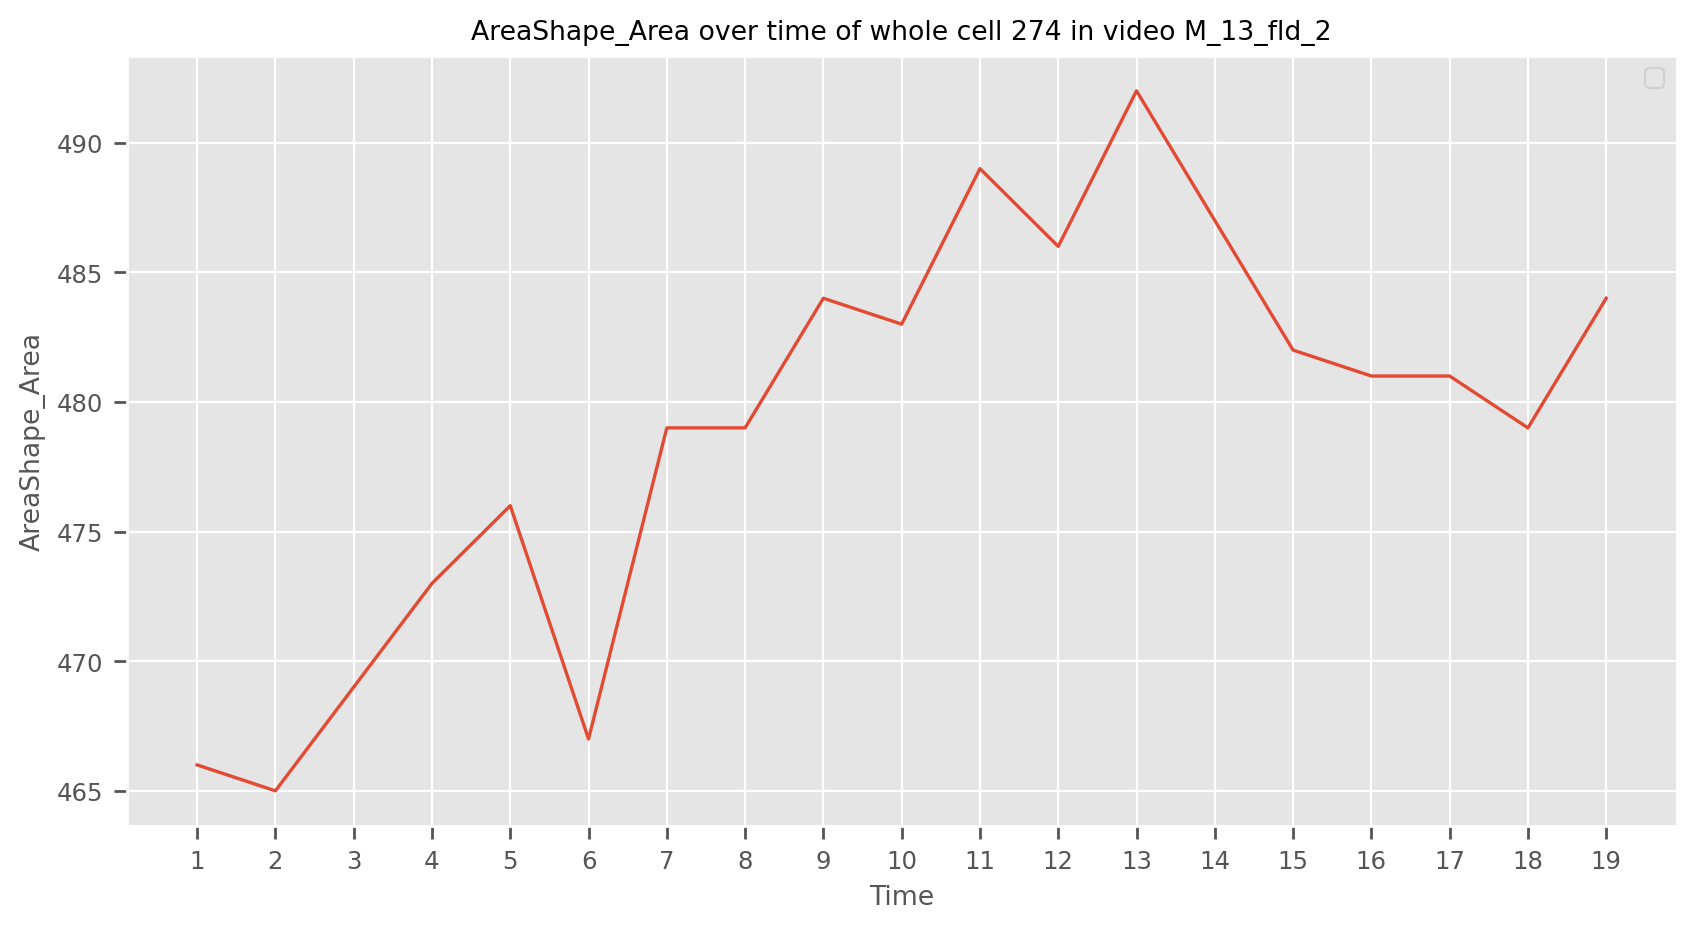

In [207]:
plt.figure(dpi=200, figsize=(10, 5))

plt.plot(df_this_vid_this_object[feature].reset_index(drop=True))
plt.xticks(
    ticks=range(len(df_this_vid_this_object)),
    labels=range(1, len(df_this_vid_this_object) + 1),
)
plt.title(f"{feature} over time of whole cell {int(float(object_number))} in video {video_id}")
plt.ylabel(f"{feature}")
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.show()

# Save timeseries of all features for all tracked objects

In [208]:
list(df_this_vid_this_object.columns)

['ImageNumber',
 'ObjectNumber',
 'Metadata_FileLocation',
 'Metadata_Frame',
 'Metadata_Series',
 'Metadata_VideoID',
 'Metadata_VideoID.1',
 'Metadata_Well',
 'Metadata_column',
 'Metadata_field',
 'Metadata_row',
 'Metadata_time',
 'FileName_base_images',
 'PathName_base_images',
 'AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_Equival

In [209]:
features_to_save = [
    feat for feat in df.columns if feat.startswith("AreaShape") or feat.startswith("Location")
]

# add meta data, including global_object_id and time
features_to_save += ["file", "Metadata_time", "global_object_id"]

print(f"Saving {len(features_to_save)} features or meta data")
features_to_save

Saving 114 features or meta data


['AreaShape_Area',
 'AreaShape_BoundingBoxArea',
 'AreaShape_BoundingBoxMaximum_X',
 'AreaShape_BoundingBoxMaximum_Y',
 'AreaShape_BoundingBoxMinimum_X',
 'AreaShape_BoundingBoxMinimum_Y',
 'AreaShape_Center_X',
 'AreaShape_Center_Y',
 'AreaShape_CentralMoment_0_0',
 'AreaShape_CentralMoment_0_1',
 'AreaShape_CentralMoment_0_2',
 'AreaShape_CentralMoment_0_3',
 'AreaShape_CentralMoment_1_0',
 'AreaShape_CentralMoment_1_1',
 'AreaShape_CentralMoment_1_2',
 'AreaShape_CentralMoment_1_3',
 'AreaShape_CentralMoment_2_0',
 'AreaShape_CentralMoment_2_1',
 'AreaShape_CentralMoment_2_2',
 'AreaShape_CentralMoment_2_3',
 'AreaShape_Compactness',
 'AreaShape_ConvexArea',
 'AreaShape_Eccentricity',
 'AreaShape_EquivalentDiameter',
 'AreaShape_EulerNumber',
 'AreaShape_Extent',
 'AreaShape_FormFactor',
 'AreaShape_HuMoment_0',
 'AreaShape_HuMoment_1',
 'AreaShape_HuMoment_2',
 'AreaShape_HuMoment_3',
 'AreaShape_HuMoment_4',
 'AreaShape_HuMoment_5',
 'AreaShape_HuMoment_6',
 'AreaShape_InertiaTens

In [210]:
features_through_time = df_full_lifetimes[features_to_save].copy(deep=False)
features_through_time

,AreaShape_Area,AreaShape_BoundingBoxArea,AreaShape_BoundingBoxMaximum_X,AreaShape_BoundingBoxMaximum_Y,AreaShape_BoundingBoxMinimum_X,AreaShape_BoundingBoxMinimum_Y,AreaShape_Center_X,AreaShape_Center_Y,AreaShape_CentralMoment_0_0,AreaShape_CentralMoment_0_1,...,AreaShape_Zernike_9_3,AreaShape_Zernike_9_5,AreaShape_Zernike_9_7,AreaShape_Zernike_9_9,Location_Center_X,Location_Center_Y,Location_Center_Z,file,Metadata_time,global_object_id
1,341,475,856,29,837,4,845.832845,15.756598,341.0,1.705303e-13,...,0.003164,0.004300,0.001652,0.004044,845.832845,15.756598,0,filtered_nucleus,1,A_13_fld_2-2.0
3,448,594,237,34,215,7,226.008929,20.006696,448.0,-3.019807e-14,...,0.002486,0.006420,0.002873,0.001427,226.008929,20.006696,0,filtered_nucleus,1,A_13_fld_2-4.0
4,362,462,339,37,318,15,327.845304,25.292818,362.0,1.687539e-13,...,0.013196,0.007832,0.003510,0.007984,327.845304,25.292818,0,filtered_nucleus,1,A_13_fld_2-5.0
5,344,462,811,38,789,17,799.860465,26.598837,344.0,1.278977e-13,...,0.005064,0.004101,0.002472,0.004741,799.860465,26.598837,0,filtered_nucleus,1,A_13_fld_2-6.0
7,418,506,569,45,546,23,557.155502,33.600478,418.0,-3.410605e-13,...,0.003469,0.001258,0.001727,0.000956,557.155502,33.600478,0,filtered_nucleus,1,A_13_fld_2-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146351,430,598,218,999,192,976,204.083721,987.844186,430.0,-4.121148e-13,...,0.005316,0.003024,0.006118,0.004126,204.083721,987.844186,0,whole_cell,19,O_14_fld_3-390.0
2146352,437,572,412,999,390,973,400.686499,985.519451,437.0,2.842171e-13,...,0.003612,0.003906,0.006549,0.002087,400.686499,985.519451,0,whole_cell,19,O_14_fld_3-389.0
2146353,424,575,240,1004,217,979,227.327830,991.363208,424.0,2.504663e-13,...,0.003230,0.010038,0.001725,0.003735,227.327830,991.363208,0,whole_cell,19,O_14_fld_3-393.0
2146354,473,644,843,1002,815,979,828.361522,989.365751,473.0,-4.991563e-13,...,0.007800,0.006269,0.007273,0.008373,828.361522,989.365751,0,whole_cell,19,O_14_fld_3-392.0


In [211]:
df_full_lifetimes["global_object_id"].nunique(dropna=False)

45757

## Save

In [212]:
data_path

PosixPath('analyses/biotine_resized')

In [ ]:
save_path = data_path / "features_through_time_of_full_lifetime_cells.parquet"
if save_path.exists():
    raise RuntimeError(f"{save_path} already exists")

features_through_time.to_parquet(save_path, index=False)